<a href="https://colab.research.google.com/github/sthalles/logistic-regression/blob/master/Softmax_Logistic_Regression_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from numpy.linalg import pinv, inv
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split

In [0]:
class DataSet:
  def __init__(self, data, targets, valid_classes=None):
    if valid_classes is None:
      self.valid_classes = np.unique(targets)
    else:
      self.valid_classes = valid_classes
    #print(self.valid_classes)
    self.number_of_classes = len(self.valid_classes)
    self.data = self.to_dict(data, targets)
    
    total = 0
    for i in self.data.keys():
      print("Class {0} # of records: {1}".format(i,len(self.data[i])))
      total += len(self.data[i])
    print("Total:",total)
    
  def to_dict(self, data, targets):
    data_dict = {}
    for x, y in zip(data, targets):
      if y in self.valid_classes:
        if y not in data_dict:
          data_dict[y] = [x.flatten()]
        else:
          data_dict[y].append(x.flatten())

    for i in self.valid_classes:
      data_dict[i] = np.asarray(data_dict[i])

    return data_dict

  def get_data_by_class(self, class_id):
    if class_id in self.valid_classes:
      return self.data[class_id]
    else:
      raise ("Class not found.")

  def get_data_as_dict(self):
    return self.data

  def get_all_data(self):
    data = []
    labels = []
    for label, class_i_data in self.data.items():
      data.extend(class_i_data)
      labels.extend(class_i_data.shape[0] * [label])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [3]:
n_points = 70
Ax = np.random.normal(1.2, 1.0, n_points)
Ay = np.random.normal(2.9, 0.3, n_points)
classA = np.column_stack((Ax,Ay))

Bx = np.random.normal(3.8, 1.0, n_points)
By = np.random.normal(1.6, 0.3, n_points)
classB = np.column_stack((Bx,By))

Cx = np.random.normal(8.5, 1.2, n_points)
Cy = np.random.normal(2.5, 0.2, n_points)
classC = np.column_stack((Cx,Cy))

labelA = np.full((classC.shape[0]), 0)
labelB = np.full((classC.shape[0]), 1)
labelC = np.full((classC.shape[0]), 2)
targets = np.concatenate((labelA,labelB,labelC),axis=0)

data = np.concatenate((classA,classB,classC), axis=0)
data_dict = {0: classA, 1:classB, 2:classC}

print(data.shape)
print(targets.shape)

(210, 2)
(210,)


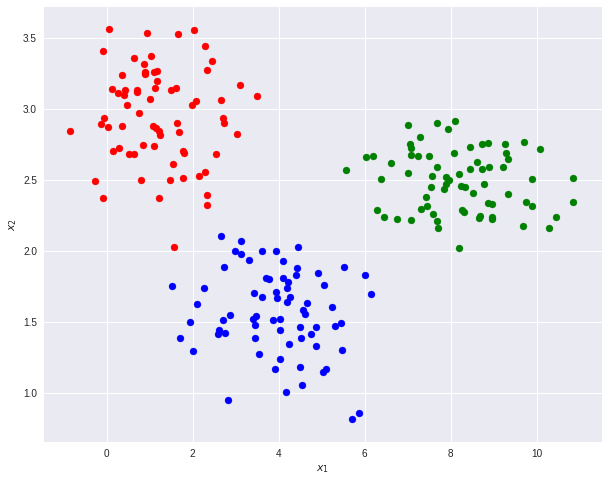

In [4]:
plt.figure(figsize=(10,8))
colors=['red','blue','green']
for point,pred in zip(data,targets):
  plt.scatter(point[0],point[1],color=colors[pred])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

In [5]:
train_dataset = DataSet(data, targets)
x_train, y_train = train_dataset.get_all_data()

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

Class 0 # of records: 70
Class 1 # of records: 70
Class 2 # of records: 70
Total: 210


In [0]:
def to_one_hot(targets,k):
  onehot = np.zeros((targets.shape[0], k))
  for i,t in enumerate(targets):
    onehot[i][t] = 1
  return onehot

class LogisticRegression:
  def __init__(self,fit_intercept=True):
    self.fit_intercept = fit_intercept
    self.W = None
  
  def score(self,X,y):
    """
    X: Logits from softmax(W^Tx). shape: [N,K]
    y: true targets. shape [N]
    """
    if self.fit_intercept:
      X = self.add_intercept(X)    
      
    logits = self.forward(X)
    pred = np.argmax(logits,axis=1)
    return np.sum(pred == y) / len(y)
    
  def predict(self,X):
    """
    X: Logits from softmax(W^Tx). shape: [N,K]
    """
    if self.fit_intercept:
      X = self.add_intercept(X)    
      
    logits = self.forward(X)
    pred = np.argmax(logits,axis=1)
    return pred
    
  def _softmax(self, a):
    """
    a: Linear combination of inputs and weights: shape: [N,K] 
    """
    return np.exp(a) / np.sum(np.exp(a), axis=-1, keepdims=True)
    
  def forward(self,X):
    """
    Model the posterior probability P(Ck|x) as a softmax function on the linear combination of inputs X and weights W.
    X: inputs, shape: [N,K]
    return: softmax transformation probabilities.
    """
    logits = np.dot(X,self.W)
    
    safe_logits = logits - np.max(logits, axis=-1, keepdims=True)
    return self._softmax(logits) # the order dot(x,W) seems correct

  def add_intercept(self,x):
    # generate a NxM design matrix, with an added column of 1
    const = np.ones((x.shape[0],1))
    return np.concatenate((const,x),axis=1)

  def fit(self,X,y,iterations=2):
    """
    Fit K-1 lines to the input data X.
    X: inputs, shape: [N,K]
    y: true targets. shape [N]
    iterations: max number of iterations for training
    """
    if self.fit_intercept:
      X = self.add_intercept(X)
    
    k = len(np.unique(y))
    d = X.shape[1]
    dk = d*k
    
    print("Input shape:",X.shape)
    print("# classes: {0} features dim:{1}".format(k,d))
    
    # convert the labels to one-hot encoding
    y = to_one_hot(y, k)
    
    HT = np.zeros((d,k,d,k))
      
    if self.W is None:
      self.W = np.zeros([d, k])
      W_shape = self.W.shape
    
    for i in range(iterations):
      logits = self.forward(X)
      for i in range(k):
        for j in range(k):
          r = np.multiply(logits[:,i],((i==j)-logits[:,j]))  ## r has negative value, so cannot use sqrt
          HT[:,i,:,j] = np.dot(np.multiply(X.T,r),X) # 4.110      
      
      G = np.dot(X.T,(logits-y))
      H = np.reshape(HT,(dk,dk))
      print("Hessian:",H.shape)
      self.W = self.W.reshape(-1) - np.dot(pinv(H), G.reshape(-1)) # 4.92
      # W = W - 0.001 * G
      # print(np.min(W),np.max(W))
      self.W = np.reshape(self.W,W_shape)

In [7]:
clf = LogisticRegression(fit_intercept=True)
clf.fit(x_train,y_train,iterations=10)
print("Test acc:",clf.score(x_test,y_test))

Input shape: (168, 3)
# classes: 3 features dim:3
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Hessian: (9, 9)
Test acc: 1.0


In [8]:
clf.W

array([[-10.9271123 ,  41.23235382, -30.55043405],
       [ -8.23271273,   1.59367287,   5.19761835],
       [ 15.27338486, -20.11729979,   4.20452971]])

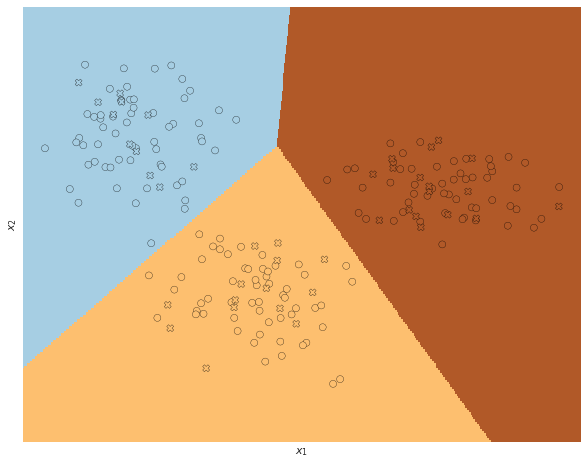

In [32]:
x_min, x_max = x_train[:, 0].min() - .5, x_train[:, 0].max() + .5
y_min, y_max = x_train[:, 1].min() - .5, x_train[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10,8))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolors='k', marker="X", cmap=plt.cm.Paired)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train, y_train)
print("Test acc:",clf.score(x_test,y_test))
print(clf.coef_, clf.intercept_)

Test acc: 1.0
[[-1.51000441  1.64888975]
 [-0.13262422 -2.52163236]
 [ 1.64262863  0.87274261]] [ 1.98501325  7.79353039 -9.77854364]


(119568,)


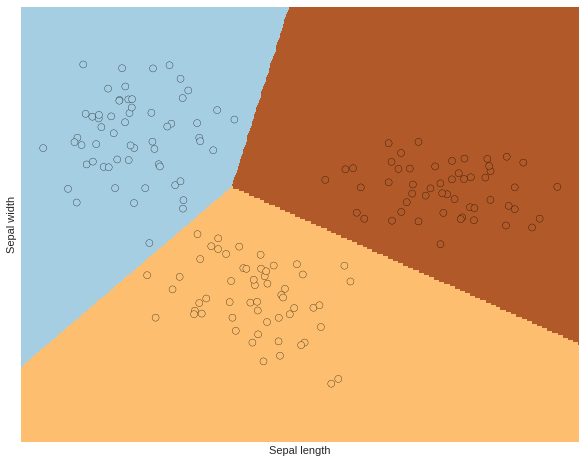

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = x_train
Y = y_train

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
print(Z.shape)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10,8))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()